# Time-Series with ARIMA and LSTM

### Goal

Forecast the number and types of disasters for upcoming months/years to support disaster management planning.

Download the [dataset here](https://www.kaggle.com/datasets/fema/federal-disasters/data).

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("darkgrid")

## Load Data

In [2]:
df = pd.read_csv("../data/database.csv")
df.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [3]:
df.shape

(46185, 14)

In [4]:
diff_date = df["Declaration Date"] != df["Start Date"]
diff_date.value_counts()

True     36458
False     9727
Name: count, dtype: int64

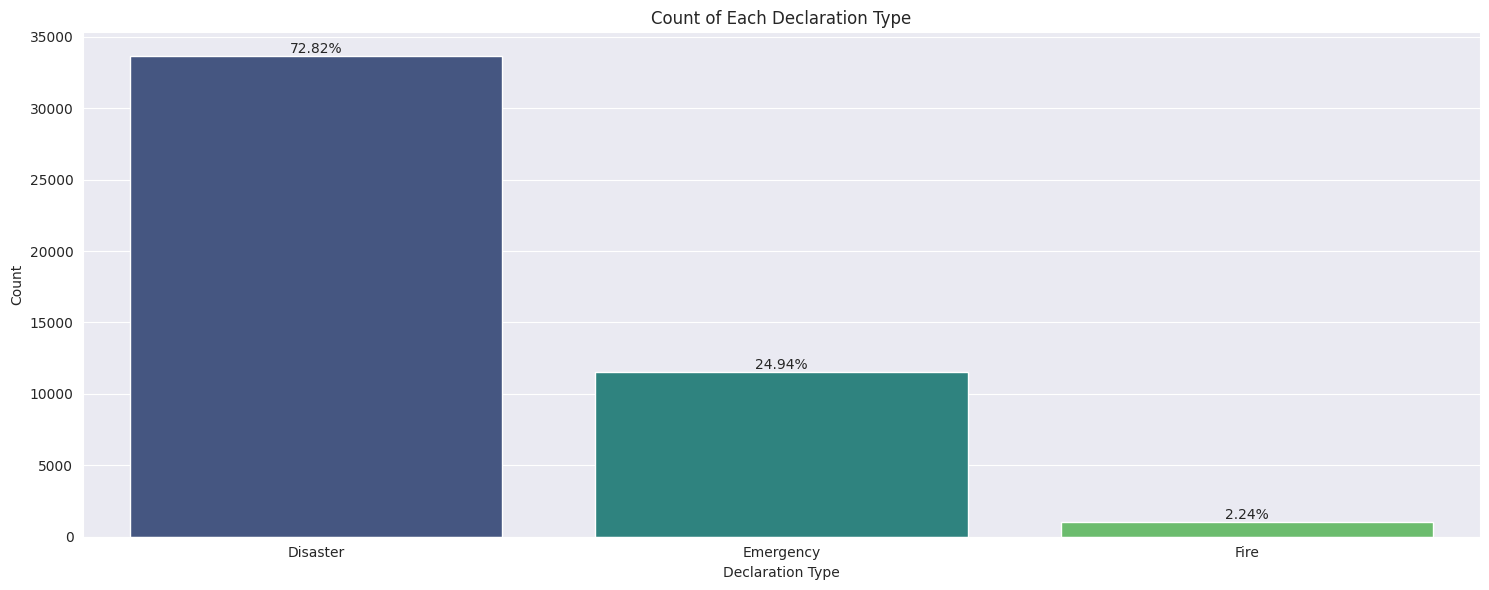

In [5]:
# Get the value counts of 'Declaration Type'
declaration_type_counts = df['Declaration Type'].value_counts()

# Calculate the percentage of each declaration type
total_count = declaration_type_counts.sum()
percentages = (declaration_type_counts / total_count) * 100

# Plot the value counts using seaborn barplot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=declaration_type_counts.index, y=declaration_type_counts.values, hue=declaration_type_counts.index, palette='viridis')

# Add labels and title
plt.xlabel('Declaration Type')
plt.ylabel('Count')
plt.title('Count of Each Declaration Type')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout();


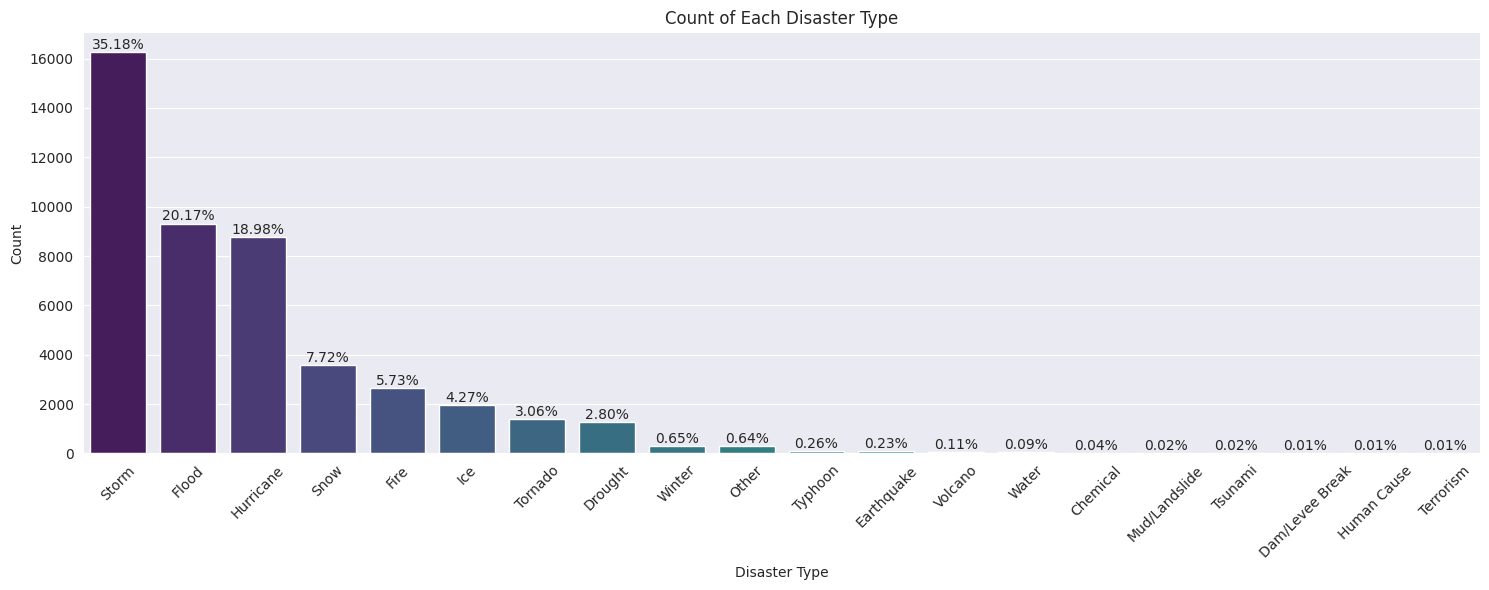

In [6]:
# Get the value counts of 'Disaster Type'
disaster_type_counts = df['Disaster Type'].value_counts()

# Calculate the percentage of each disaster type
total_count = disaster_type_counts.sum()
percentages = (disaster_type_counts / total_count) * 100

# Plot the value counts using seaborn barplot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=disaster_type_counts.index, y=disaster_type_counts.values, hue=disaster_type_counts.index, palette='viridis')

# Add labels and title
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Count of Each Disaster Type')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=45)  
plt.tight_layout();

In [7]:
# Convert dates to datetime and set index
df['Declaration Date'] = pd.to_datetime(df['Declaration Date'])
df.set_index('Declaration Date', inplace=True)

# Aggregate disaster counts by year
count_of_disasters_df = df.resample('ME').size().reset_index(name='count_of_disaster')

In [8]:
count_of_disasters_df.head()

,Declaration Date,count_of_disaster
0,1953-05-31,3
1,1953-06-30,6
2,1953-07-31,1
3,1953-08-31,0
4,1953-09-30,0


In [9]:
count_of_disasters_df1 = count_of_disasters_df.copy()
# Set 'Declaration Date' as index for the resampled data
count_of_disasters_df1.set_index('Declaration Date', inplace=True)

# Ensure the time series data is from the 'count' column
time_series_data = count_of_disasters_df1['count_of_disaster']

# Ensure the frequency is set correctly (monthly data in this case)
time_series_data = time_series_data.asfreq('ME')

In [10]:
time_series_data.head()

Declaration Date
1953-05-31    3
1953-06-30    6
1953-07-31    1
1953-08-31    0
1953-09-30    0
Freq: ME, Name: count_of_disaster, dtype: int64

In [11]:
are_equal = time_series_data.equals(count_of_disasters_df)
print(are_equal)

False


In [12]:
# Convert the Series to DataFrame
time_series_data_df = time_series_data.to_frame()

# Now compare both DataFrames
are_equal = count_of_disasters_df.equals(time_series_data_df)
print(are_equal)

False


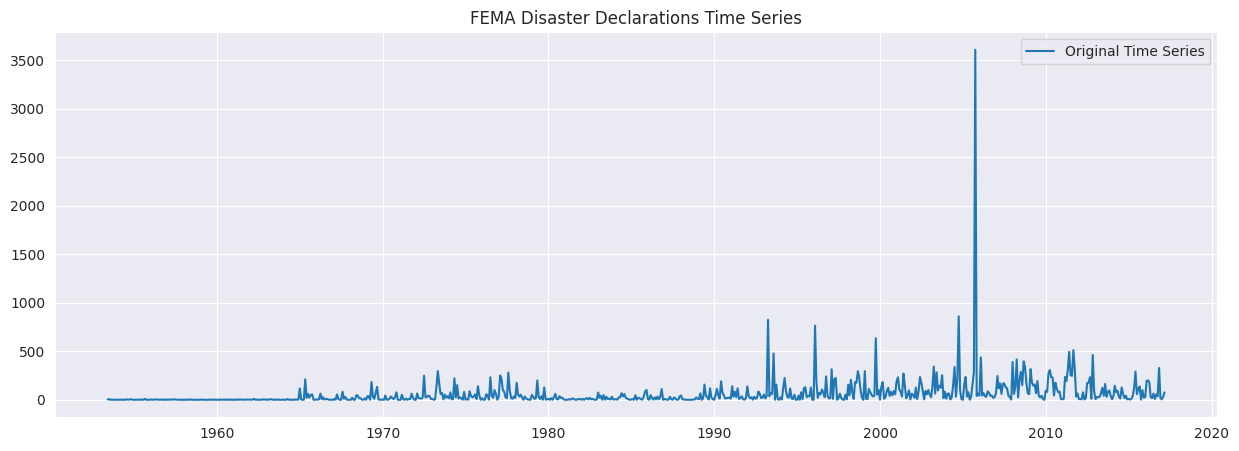

In [13]:
# Plot the time series data
plt.figure(figsize=(15, 5))
plt.plot(time_series_data, label='Original Time Series')
plt.title('FEMA Disaster Declarations Time Series')
plt.legend()
plt.show()

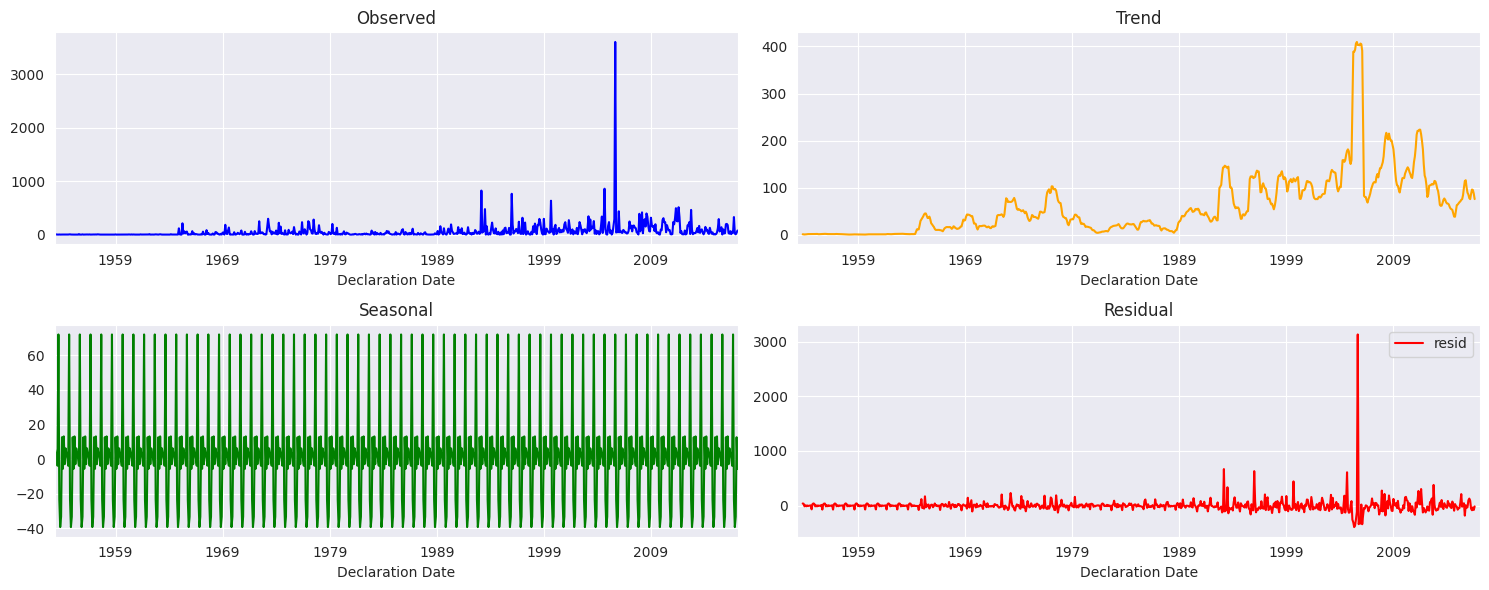

In [14]:
# Decompose the time series
decompose_result = seasonal_decompose(time_series_data, model='additive')

fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Plot each component in a separate subplot
decompose_result.observed.plot(ax=axes[0, 0], title='Observed', color='blue')
decompose_result.trend.plot(ax=axes[0, 1], title='Trend', color='orange')
decompose_result.seasonal.plot(ax=axes[1, 0], title='Seasonal', color='green')
decompose_result.resid.plot(ax=axes[1, 1], title='Residual', color='red')

plt.legend()
plt.tight_layout();

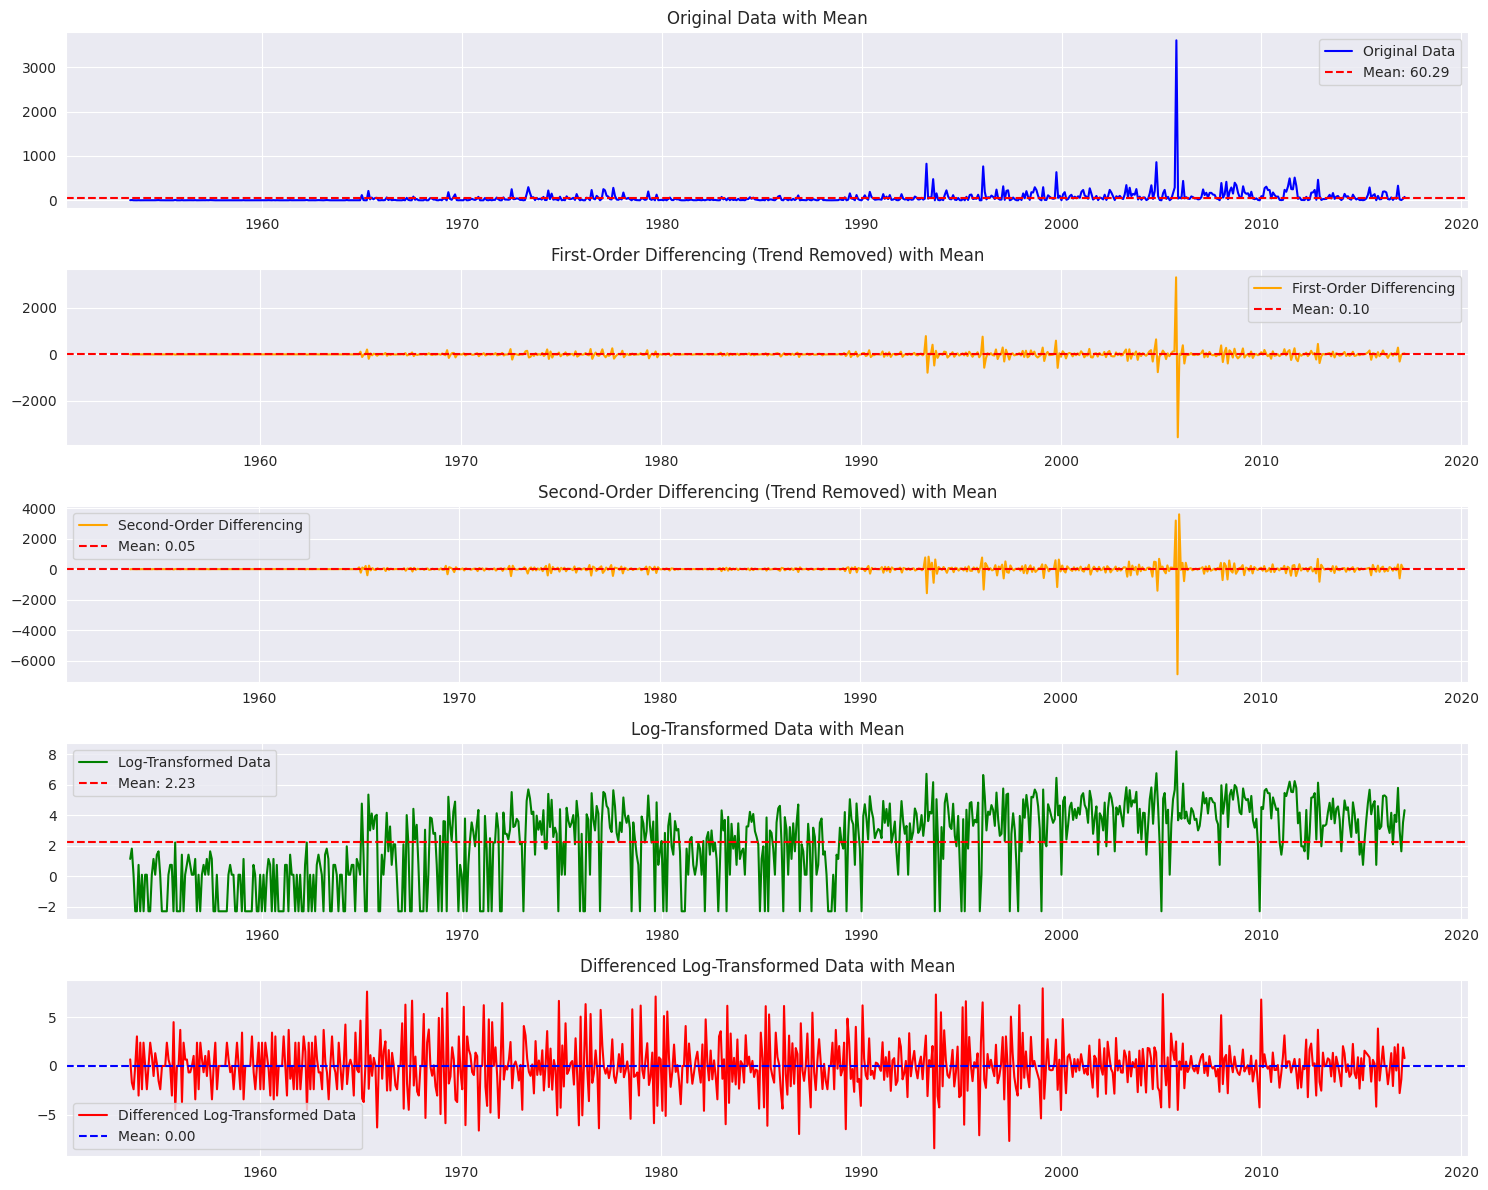

In [15]:
first_differenced = time_series_data.diff().dropna() # First Differenced Data

second_differenced = first_differenced.diff().dropna() # Second Differenced Data

log_transformed = np.log(time_series_data + .1).replace(-np.inf, np.nan).dropna() # Log-Transformed Data

log_diff = log_transformed.diff().dropna() # Differenced Log-Transformed Data

# Calculate means for each transformation
original_mean = time_series_data.mean()
first_differenced_mean = first_differenced.mean()
second_differenced_mean = second_differenced.mean()
log_transformed_mean = log_transformed.mean()
log_diff_mean = log_diff.mean()

# Plot the Original Data with mean
plt.figure(figsize=(15, 12))
plt.subplot(5, 1, 1)
plt.plot(time_series_data, label="Original Data", color='blue')
plt.axhline(original_mean, color='red', linestyle='--', label=f"Mean: {original_mean:.2f}")
plt.title("Original Data with Mean")
plt.legend()

# Plot the First Differenced Data with mean
plt.subplot(5, 1, 2)
plt.plot(first_differenced, label="First-Order Differencing", color='orange')
plt.axhline(first_differenced_mean, color='red', linestyle='--', label=f"Mean: {first_differenced_mean:.2f}")
plt.title("First-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Second Differenced Data with mean
plt.subplot(5, 1, 3)
plt.plot(second_differenced, label="Second-Order Differencing", color='orange')
plt.axhline(second_differenced_mean, color='red', linestyle='--', label=f"Mean: {second_differenced_mean:.2f}")
plt.title("Second-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Log-Transformed Data with mean
plt.subplot(5, 1, 4)
plt.plot(log_transformed, label="Log-Transformed Data", color='green')
plt.axhline(log_transformed_mean, color='red', linestyle='--', label=f"Mean: {log_transformed_mean:.2f}")
plt.title("Log-Transformed Data with Mean")
plt.legend()  

# Plot the Differenced Log-Transformed Data with mean
plt.subplot(5, 1, 5)
plt.plot(log_diff, label="Differenced Log-Transformed Data", color='red')
plt.axhline(log_diff_mean, color='blue', linestyle='--', label=f"Mean: {log_diff_mean:.2f}")
plt.title("Differenced Log-Transformed Data with Mean")
plt.legend()

plt.tight_layout();

### Stationary Check

#### Which Test Should We Choose: ADF or KPSS?

Choosing between the ADF and KPSS tests can sometimes be confusing. A practical approach is to apply both tests and cross-check their conclusions to confirm if the series is truly stationary. The following outcomes can help interpret the results:
- **Case 1:** Both tests conclude that the series is not stationary - The series is not stationary
- **Case 2:** Both tests conclude that the series is stationary - The series is stationary
- **Case 3:** KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [16]:
# ADF Test
def adf_test(timeseries, regression='c'):
    """
    Perform Augmented Dickey-Fuller (ADF) Test.

    Parameters:
    timeseries: The time series data.
    regression: {'c', 'ct', 'ctt', 'n}.
                'c' : constant only (default). 
                'ct' : constant and trend.
                'ctt' : constant, and linear and quadratic trend.
                'nc' : no constant, no trend.
    
    Returns:
    Results of the ADF test in a Pandas Series.
    """
    print("ADF Test:\n")
    print("Null Hypothesis (H0): The series has a unit root or is non-stationary.")
    print("Alternate Hypothesis (H1): The series has no unit root or is stationary.\n")
    print("Results of Dickey-Fuller Test:\n")
    adf_result = adfuller(timeseries, regression=regression, autolag='AIC')
    adf_output = pd.Series(
        adf_result[0:4], index=["Test Statistic", "p-value", "Lags Used", "Observations Used"]
    )
    for key, value in adf_result[4].items():
        adf_output[f"Critical Value ({key})"] = value
    print(adf_output,'\n')
    
    if adf_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is stationary.\n")
    else:
        print("Fail to Reject H0: The series is non-stationary.\n")
        

# KPSS Test
def kpss_test(timeseries, regression='c'):
    """
    Perform KPSS Test.

    Parameters:
    timeseries: The time series data.
    regression: 'c' for constant, 'ct' for constant and trend.
    
    Returns:
    Results of the KPSS test in a Pandas Series.
    """
    print("KPSS Test:\n")
    print("Null Hypothesis (H0): The series is trend stationary or has no unit root.")
    print("Alternate Hypothesis (H1): The series has a unit root (is non-stationary).\n")
    print("Results of KPSS Test:\n")
    kpss_result = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(
        kpss_result[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_result[3].items():
        kpss_output[f"Critical Value ({key})"] = value
    print(kpss_output,'\n')
    
    if kpss_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is non-stationary.\n")
    else:
        print("Fail to Reject H0: The series is stationary.\n")


In [17]:
# Check stationarity with ADF Test
adf_test(time_series_data, regression='ct') 

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -6.544486e+00
p-value                 1.473011e-07
Lags Used               1.100000e+01
Observations Used       7.540000e+02
Critical Value (1%)    -3.970827e+00
Critical Value (5%)    -3.416329e+00
Critical Value (10%)   -3.130486e+00
dtype: float64 

Reject H0: The series is stationary.



In [18]:
# Check stationarity with KPSS Test
kpss_test(time_series_data, regression='ct')

KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic           0.171615
p-value                  0.028654
Lags Used                8.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64 

Reject H0: The series is non-stationary.



Check Stationarity with ADF and KPSS Test:
- **Based on the ADF Test, the series is stationary** because the p-value is less than the significant level 0.05, leading to the rejection of the null hypothesis.
- **Based on the KPSS Test, the series is non-stationary** because the p-value is less than the significant level 0.05, leading to the rejection of the null hypothesis.
- **Conclusion: The series is difference stationary.** Differencing is to be used to make series stationary. 

In [19]:
def diff_inv(series_diff, first_value):
    return np.cumsum(np.insert(series_diff, 0, first_value))


# Original series
original_series = pd.Series([100, 102, 105, 110, 115])

# Apply differentiation
series_diff = original_series.diff().dropna()

# Invert differentiation
first_value = original_series.iloc[0]
reconstructed_series = diff_inv(series_diff, first_value)

print("Original series:", original_series.values)
print("Differentiation series", series_diff)
print("Reconstructed series:", reconstructed_series)

Original series: [100 102 105 110 115]
Differentiation series 1    2.0
2    3.0
3    5.0
4    5.0
dtype: float64
Reconstructed series: [100. 102. 105. 110. 115.]


In [20]:
# Apply differencing to make the series stationary
time_series_data_diff = time_series_data.diff().dropna()

In [21]:
# Recheck for strict stationarity.
adf_test(time_series_data_diff, regression='ct')
print() 
kpss_test(time_series_data_diff, regression='ct')

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -1.323496e+01
p-value                 6.963061e-21
Lags Used               1.400000e+01
Observations Used       7.500000e+02
Critical Value (1%)    -3.970892e+00
Critical Value (5%)    -3.416360e+00
Critical Value (10%)   -3.130504e+00
dtype: float64 

Reject H0: The series is stationary.


KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic            0.028874
p-value                   0.100000
Lags Used                39.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64 

Fail to Reject H0: The series is stationary.



/tmp/ipykernel_777096/1974365690.py:51: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression=regression, nlags="auto")


#### Determining $p$ and $q$ from PACF and ACF:

- `Cuts off`: The value drops abruptly to zero.
- `Tails off`: The value gradually decays towards zero, usually in an exponential way.

- Select $p$ based on significant spikes from the PACF plot. 
    - One clue is that the ACF plot decays more slowly.
- Select $q$ from ACF if this plot has a sharp cut-off after lag $q$. 
    - One clue is that the PACF plot decays more slowly.

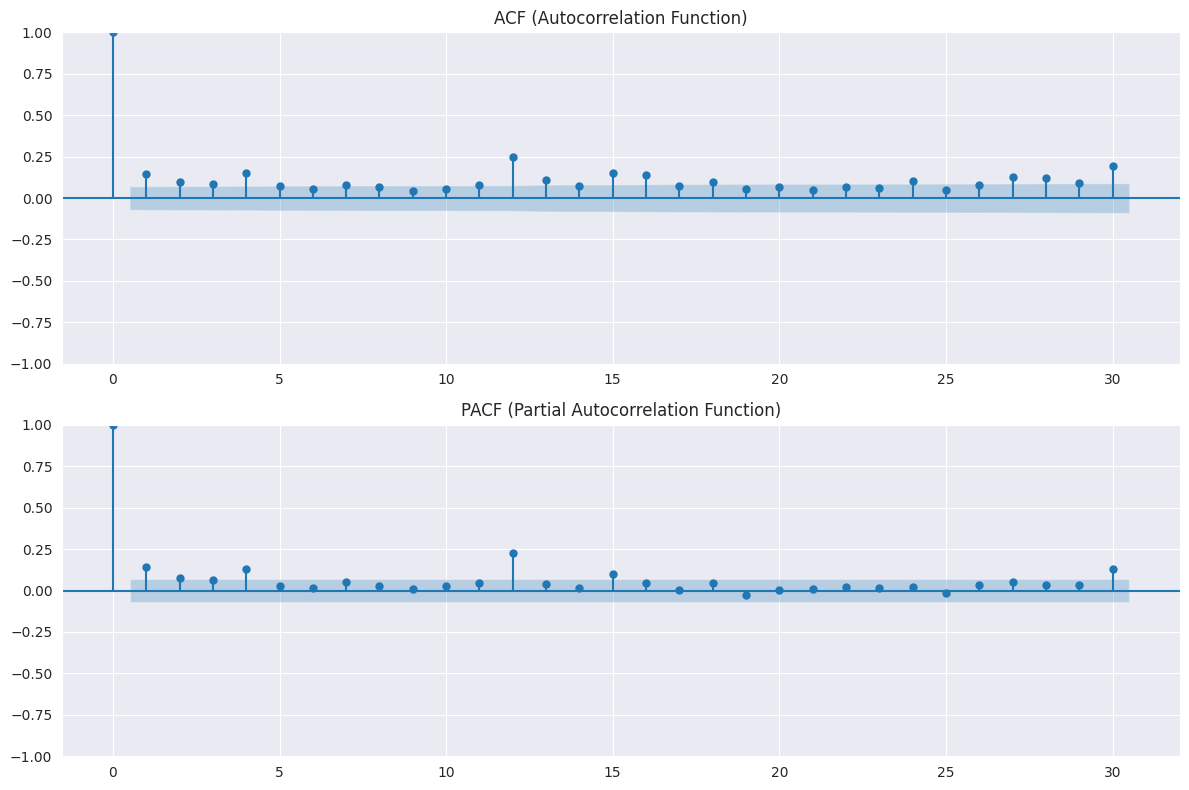

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF (Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_acf(time_series_data, lags=30, alpha=0.05, ax=ax1)  
ax1.set_title('ACF (Autocorrelation Function)')

# Plot PACF (Partial Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_pacf(time_series_data, lags=30, alpha=0.05, ax=ax2)  
ax2.set_title('PACF (Partial Autocorrelation Function)')

plt.tight_layout();

- From the ACF plot, the twelfth lag stands out the most, indicating a clear **seasonal pattern** that repeats **every 12 months**, as the data is monthly.
- Once again, the **twelfth** lag is the most prominent in the PACF plot.

# LSTM

The Long Short Term Memory (LSTM) is the advanced type of RNN, which was designed to prevent both decaying and exploding gradient problems. Just like RNN, LSTM has repeating modules, but the structure is different. Instead of having a single layer of tanh, LSTM has four interacting layers that communicate with each other. This four-layered structure helps LSTM retain long-term memory and can be used in several sequential problems including machine translation, speech synthesis, speech recognition, and handwriting recognition.

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

from scipy import stats
import tensorflow as tf
import statsmodels.api as sm
from tensorflow.random import set_seed
from tsaug import TimeWarp, Drift, AddNoise
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import MinMaxScaler, RobustScaler


SEED = 29
set_seed(SEED)
np.random.seed(SEED)

In [24]:
series_to_df = time_series_data.to_frame()
series_to_df.head()

,count_of_disaster
Declaration Date,
1953-05-31,3
1953-06-30,6
1953-07-31,1
1953-08-31,0
1953-09-30,0


In [25]:
series_to_df.isnull().sum()

count_of_disaster    0
dtype: int64

Skewness: 14.87
Kurtosis: 313.18


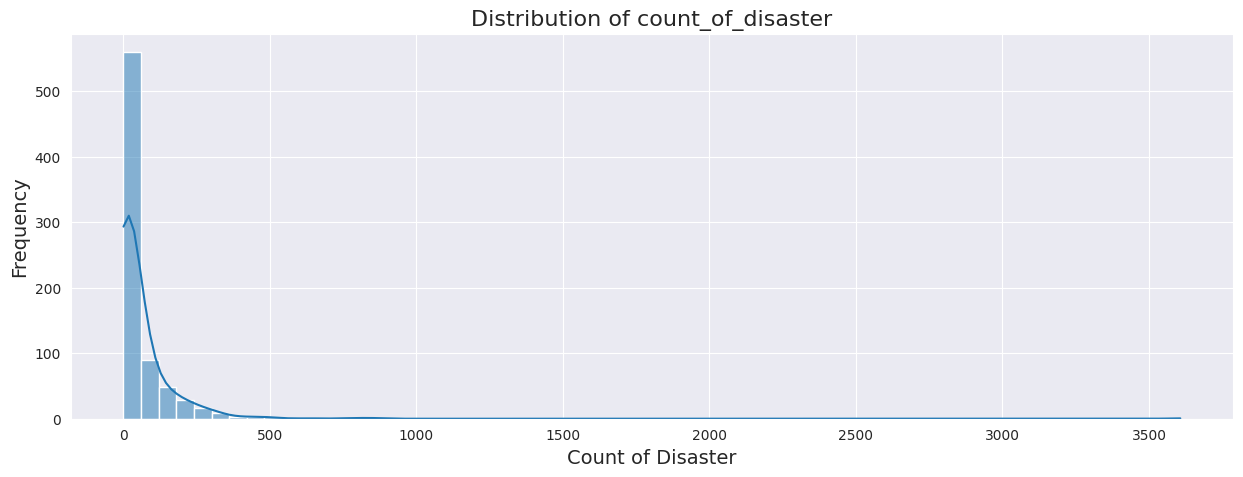

In [26]:
skewness = series_to_df['count_of_disaster'].skew()
kurtosis_value = series_to_df['count_of_disaster'].kurt()

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis_value:.2f}")

plt.figure(figsize=(15, 5))
sns.histplot(series_to_df['count_of_disaster'], kde=True, bins=60)

plt.title('Distribution of count_of_disaster', fontsize=16)
plt.xlabel('Count of Disaster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.grid(True);

- The skewness of `count_of_disaster` is **14.87**, and the kurtosis is 3**13.18**, indicating that the distribution is **heavily right-skewed.**
- Additionally, the variable is **not normally distributed**, so we will use either `MinMaxScaler` or `RobustScaler`.

## Data Preparation

In [27]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, batch_size=32):
        """
        Initialize the WindowGenerator for univariate time series data.

        Args:
            input_width (int): The number of input time steps.
            label_width (int): The number of label time steps.
            shift (int): The time step shift between input and label.
            train_df (np.ndarray): Training data (scaled).
            val_df (np.ndarray): Validation data (scaled).
            test_df (np.ndarray): Test data (scaled).
            batch_size (int): Batch size for the dataset.
        """
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.label_start = self.total_window_size - label_width
        self.labels_slice = slice(self.label_start, None)

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

    def split_window(self, window):
        """
        Splits a window of data into inputs and labels.

        Args:
            window (np.ndarray): A window of data.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Inputs and labels.
        """
        inputs = window[:, self.input_slice, :]
        labels = window[:, self.labels_slice, :]
        return inputs, labels

    def make_dataset(self, data, augment=False, augmenter=None, scaler=None, n_samples=None):
        """
        Creates a tf.data.Dataset from the input data and returns X and y.

        Args:
            data (np.ndarray): Input data for the dataset.
            augment (bool): Whether to apply augmentation.
            augmenter: Augmentation pipeline.
            scaler: Scaler for normalizing augmented data.
            n_samples (int): Desired number of augmented samples.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Inputs and labels arrays.
        """
        data = np.array(data, dtype=np.float32)  
        dataset = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size,
        )

        # Collect all windows
        X, y = [], []
        for window in dataset:
            inputs, labels = self.split_window(window)
            X.append(inputs.numpy())
            y.append(labels.numpy())

        X = np.concatenate(X, axis=0)
        y = np.concatenate(y, axis=0)

        print(f"Shape of X: {X.shape}")
        print(f"Shape of y: {y.shape}")
        
        # Handle augmentation if required
        if augment and augmenter is not None and n_samples is not None:
            X_aug, y_aug = self.augment_data(X, y, augmenter, scaler, n_samples)
            
            print(f"Shape of X augmented: {X_aug.shape}")
            print(f"Shape of y augmented: {y_aug.shape}")
            
            # Combine original data with augmented data
            X = np.concatenate([X, X_aug], axis=0)
            y = np.concatenate([y, y_aug], axis=0)
            
            print(f"Shape of X (original + augmented): {X.shape}")
            print(f"Shape of y (original + augmented): {y.shape}")

        return X, y

    def augment_data(self, X, y, augmenter, scaler, n_samples):
        """
        Augments the dataset to generate the desired number of samples.

        Args:
            X (np.ndarray): Input features.
            y (np.ndarray): Labels.
            augmenter: Augmentation pipeline.
            scaler: Scaler to normalize augmented data.
            n_samples (int): Number of desired augmented samples.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Augmented features and labels.
        """
        X_aug, y_aug = [], []

        while len(X_aug) < n_samples:
            for i in range(X.shape[0]):
                x_aug_instance, y_aug_instance = augmenter.augment(X[i].flatten(), y[i].flatten())
                x_aug_instance = scaler.transform(x_aug_instance.reshape(-1, 1)).flatten()
                y_aug_instance = scaler.transform(y_aug_instance.reshape(-1, 1)).flatten()

                X_aug.append(x_aug_instance.reshape(-1, 1))
                y_aug.append(y_aug_instance.reshape(-1, 1))

                if len(X_aug) >= n_samples:
                    break
        
        if np.isnan(np.array(X_aug)).any() or np.isnan(np.array(y_aug)).any():
            raise ValueError("NaN values detected in augmented data.")

        return np.array(X_aug), np.array(y_aug)
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)


In [28]:
# Split data into train, validation, and test sets
n = len(series_to_df)
train_df = series_to_df[0:int(n*0.7)]
val_df = series_to_df[int(n*0.7):int(n*0.9)]
test_df = series_to_df[int(n*0.9):]


# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = RobustScaler()

train_df_scaled = scaler.fit_transform(train_df[['count_of_disaster']].values)
val_df_scaled = scaler.transform(val_df[['count_of_disaster']].values)
test_df_scaled = scaler.transform(test_df[['count_of_disaster']].values)


# Initialize the WindowGenerator
window_generator = WindowGenerator(input_width=12,  # 12 months of input (1 year)
                                   label_width=12,  # 12 month of output
                                   shift=1,         # Predict the next month   
                                   train_df=train_df_scaled, 
                                   val_df=val_df_scaled, 
                                   test_df=test_df_scaled,
                                   batch_size=16)


# Get the training data as X (inputs) and y (labels)
X_train, y_train = window_generator.make_dataset(data=window_generator.train_df,
                                                 augment=True,
                                                 augmenter=None,
                                                 scaler=None,
                                                 n_samples=None)

# Get the validation data
X_val, y_val = window_generator.make_dataset(data=window_generator.val_df,
                                             augment=True,
                                             augmenter=None,
                                             scaler=None,
                                             n_samples=None)

# Get the test data
X_test, y_test = window_generator.make_dataset(data=window_generator.test_df,
                                               augment=True,
                                               augmenter=None,
                                               scaler=None,
                                               n_samples=None)



Shape of X: (524, 12, 1)
Shape of y: (524, 12, 1)
Shape of X: (141, 12, 1)
Shape of y: (141, 12, 1)
Shape of X: (65, 12, 1)
Shape of y: (65, 12, 1)


In [29]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(524, 12, 1)
(141, 12, 1)
(65, 12, 1)


In [30]:
print(np.isnan(X_train).any())
print(np.isnan(X_val).any())
print(np.isnan(X_test).any())
print(np.isnan(y_train).any())
print(np.isnan(y_val).any())
print(np.isnan(y_test).any())

False
False
False
False
False
False


In [31]:
print("Minimum value of y_train : ", np.min(y_train))
print("Maximum value of y_train : ", np.max(y_train))  
print("Average absolute value of y_train : ", np.mean(np.abs(y_train)))  
print("Count values close to zero : ", np.sum(np.abs(y_train) < 1e-5))
print()
print("Minimum value of y_val : ", np.min(y_val))
print("Maximum value of y_val : ", np.max(y_val))  
print("Average absolute value of y_val : ", np.mean(np.abs(y_val)))  
print("Count values close to zero : ", np.sum(np.abs(y_val) < 1e-5))
print()
print("Minimum value of y_test : ", np.min(y_test))
print("Maximum value of y_test : ", np.max(y_test))  
print("Average absolute value of y_test : ", np.mean(np.abs(y_test)))  
print("Count values close to zero : ", np.sum(np.abs(y_test) < 1e-5))

Minimum value of y_train :  -0.19354838
Maximum value of y_train :  26.387096
Average absolute value of y_train :  0.96178067
Count values close to zero :  157

Minimum value of y_val :  -0.19354838
Maximum value of y_val :  116.16129
Average absolute value of y_val :  4.484557
Count values close to zero :  0

Minimum value of y_test :  -0.12903225
Maximum value of y_test :  16.32258
Average absolute value of y_test :  2.9119105
Count values close to zero :  0


In [32]:
""" 
    Data Augmentation
"""



# Our augmenter
augmenter = (
    TimeWarp(n_speed_change=1, prob=0.33, seed=SEED)  # Ensure this does not violate sequence order
    + Drift(max_drift=(0.1, 0.5), seed=SEED)          # Small drift values to avoid large displacements
    + AddNoise(scale=0.5, prob=0.3, seed=SEED)        # Adding some noise for robustness
)



# Generate augmented dataset with 10,000 samples
X_train_aug, y_train_aug = window_generator.make_dataset(data=window_generator.train_df,
                                                         augment=True,
                                                         augmenter=augmenter,
                                                         scaler=scaler,
                                                         n_samples=1000)


Shape of X: (524, 12, 1)
Shape of y: (524, 12, 1)
Shape of X augmented: (1000, 12, 1)
Shape of y augmented: (1000, 12, 1)
Shape of X (original + augmented): (1524, 12, 1)
Shape of y (original + augmented): (1524, 12, 1)


In [33]:
print("Minimum value of the augmented y_train : ", np.min(y_train_aug))
print("Maximum value of the augmented y_train : ", np.max(y_train_aug))  
print("Average absolute value of the augmented y_train : ", np.mean(np.abs(y_train_aug)))  
print("Augmented data - count values close to zero : ", np.sum(np.abs(y_train_aug) < 1e-5))

Minimum value of the augmented y_train :  -0.19979188
Maximum value of the augmented y_train :  26.387096
Average absolute value of the augmented y_train :  0.44618264
Augmented data - count values close to zero :  157


In [34]:
# Apply Log Transformation to takcle Heteroscedasticity

y_train_log = np.log1p(y_train)
y_train_aug_log = np.log1p(y_train_aug)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

There's one additional rule of thumb that helps for supervised learning problems. 
We can usually prevent over-fitting if we keep our number of neurons below:

$$ N_h = \frac{N_s}{\alpha \cdot (N_i + N_o)} $$

Where:
- $N_i$ = number of input neurons.
- $N_o$ = number of output neurons.
- $N_s$ = number of samples in the training data set.
- $\alpha$ = an arbitrary scaling factor, usually between 2 and 10.

In [35]:
def calculate_hidden_units_from_data(train_data, alpha=5):
    # Ensure alpha is within the accepted range
    if alpha < 2 or alpha > 10:
        raise ValueError("Alpha must be between 2 and 10.")
    
    # Get the number of samples (N_s) and the number of input features (N_i)
    if len(train_data.shape) == 2:
        n_samples = train_data.shape[0]
        n_inputs = train_data.shape[1]
    elif len(train_data.shape) == 3:
        n_samples = train_data.shape[0]
        n_inputs = train_data.shape[2]
    else:
        print("Check the X shape")
    
    # Number of output neurons for univariate time series (N_o)
    n_outputs = 1  # For univariate time series
    
    # Calculate N_h based on the rule of thumb
    n_h = n_samples / (alpha * (n_inputs + n_outputs))
    
    return int(n_h)



# Calculate the number of hidden units: N_h 
ALPHA = 6
TRAIN_DATA = X_train_aug
hidden_units = calculate_hidden_units_from_data(TRAIN_DATA, alpha=ALPHA)
print(f"Suggested number of hidden units (N_h): {hidden_units}")


Suggested number of hidden units (N_h): 127


In [36]:
def plot_loss_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();  
    

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(15, 5))
    plt.plot(test, label="Actual")
    plt.plot(predicted, label="Predicted")
    plt.title(f"{title} - Disaster Prediction")
    plt.xlabel("Time")
    plt.ylabel("Disaster Count")
    plt.legend();
    

def perform_wilcoxon_test_and_correlation(predictions, y_original):
    # Calculate the Kendall correlation coefficient (non-normal distribution)
    kendall_corr, kendall_p_value = stats.kendalltau(predictions.flatten(), y_original.flatten())

    # Perform Wilcoxon signed-rank test to compare the actual and predicted values (non-normal distribution)
    wilcoxon_stat, wilcoxon_p_value = stats.wilcoxon(predictions.flatten(), y_original.flatten())

    print(f"\nKendall correlation coefficient (Tau): {kendall_corr}")
    print(f"P-value for Kendall correlation: {kendall_p_value}")
    print(f"Wilcoxon statistic: {wilcoxon_stat}")
    print(f"P-value from Wilcoxon signed-rank test: {wilcoxon_p_value}\n")

    print("Conclusion for Kendall's Tau:")
    if kendall_p_value < 0.05:
        print("The Kendall correlation between the prediction and the actual is statistically significant.")
    else:
        print("The Kendall correlation between the prediction and the actual is not statistically significant.")

    print("\nConclusion for Wilcoxon signed-rank test:")
    if wilcoxon_p_value < 0.05:
        print("There is a statistically significant difference between the average predicted and actual values.")
    else:
        print("There is no statistically significant difference between the average predicted and actual values.")
    

def plot_one_step_forecast(predictions, y_original, title):
    predictions_one_step = predictions.reshape(-1, 12)[:, 0]  # Take the first label in each window
    labels_one_step = y_original.reshape(-1, 12)[:, 0]        # Same for true labels

    plt.figure(figsize=(15, 5))
    plt.plot(predictions_one_step, label='Predicted', color='orange')
    plt.plot(labels_one_step, label='Actual', color='green')
    plt.title(f"{title} - Actual vs Predicted Disaster Count (One-Step Forecast)")
    plt.xlabel("Date")
    plt.ylabel("Disaster Count")
    plt.legend() 
    plt.grid(True);


def plot_residual_variance_across_prediction(prediction, residuals, title):
    prediction_1d = prediction.flatten()
    bins = np.linspace(np.min(prediction_1d), np.max(prediction_1d), num=50)
    bin_indices = np.digitize(prediction_1d, bins)
    residual_variances = [np.var(residuals[bin_indices == i]) for i in range(1, len(bins))]
    plt.figure(figsize=(15,5))
    plt.plot(bins[:-1], residual_variances, marker='o')
    plt.xlabel('Predicted Value Bins')
    plt.ylabel('Residual Variance')
    plt.title(f'{title} - Residual Variance Across Predicted Value Bins');
    
    
def plot_residuals(residuals, title):
    plt.figure(figsize=(15, 5))
    plt.hist(residuals, bins=50, edgecolor='k')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Distribution of Residuals');
    

def perform_breusch_pagan_test(predictions, residuals):
    X_val_with_const = sm.add_constant(predictions)
    bp_test = het_breuschpagan(residuals, X_val_with_const)
    bp_test_results = dict(zip(['Lagrange Multiplier Statistic', 'p-value', 'F-value', 'F p-value'], bp_test))
    bp_test_stat = bp_test_results["Lagrange Multiplier Statistic"]
    bp_p_value = bp_test_results["p-value"]    

    print("Breusch-Pagan Test Results:")
    print(f"Lagrange Multiplier Statistic: {bp_test_stat}")
    print(f"P-value: {bp_p_value}\n")
    if bp_p_value < 0.05:
        print("Heteroscedasticity detected! The variance of the residual, or error term, in the regression model is not constant.")
    else:
        print("Homoscedasticity detected! The variance of the residual, or error term, in the regression model is constant.")
         

In [37]:
################  Define custom metrics  ################

# Define a small epsilon value to avoid division by zero
epsilon = tf.keras.backend.epsilon()


# Define custom metrics with checks to avoid division by zero
def mape(y_true, y_pred):
    y_true = tf.where(y_true == 0, epsilon, y_true)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

def me(y_true, y_pred):
    return tf.reduce_mean(y_true - y_pred)

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mpe(y_true, y_pred):
    y_true = tf.where(y_true == 0, epsilon, y_true)
    return tf.reduce_mean((y_true - y_pred) / y_true) * 100

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def r2(y_true, y_pred):
    sum_squares_residuals = tf.reduce_sum(tf.square(y_true - y_pred))
    sum_squares_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1.0 - tf.divide(sum_squares_residuals, sum_squares_total)


def weighted_huber_loss(y_true, y_pred):
    residuals = tf.abs(y_true - y_pred)
    weights = 1 / (1 + residuals)  
    huber_loss = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    return tf.reduce_mean(weights * huber_loss)

def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)



def compile_and_fit(model, x_train, y_t, x_val, y_v, patience=5, max_epochs=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      restore_best_weights=True,
                                                      mode='min')

    # Learning rate scheduler to reduce LR on plateau
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.3, 
                                                        patience=2, 
                                                        min_lr=1e-6)
    
    # # Model checkpoint to save the best model
    # checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', 
    #                                                  monitor='val_loss', 
    #                                                  save_best_only=True, 
    #                                                  mode='min')

    # Compile the model with Adam optimizer and custom metrics
    model.compile(loss=huber_loss, #weighted_huber_loss, huber_loss, tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Adam or RMSprop
                  metrics=[r2, me, mse, mae, rmse, mape, mpe])
    

    # Fit the model with additional callbacks
    history = model.fit(x_train, y_t,
                        epochs=max_epochs,
                        validation_data=(x_val, y_v),
                        callbacks=[early_stopping, lr_scheduler]) # [early_stopping, lr_scheduler, checkpoint]
    return history

In [38]:
# Define hyperparameters
HIDDEN_UNITS = hidden_units 
MAX_EPOCHS = 2000
PATIENCE = 20

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed = SEED)
INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)

#### LSTM Model

In [39]:
# Build the LSTM model
lstm_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),  # m timesteps, n feature per timestep
    tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    tf.keras.layers.Dropout(0.1), 
    # tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    # tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(units=1)
])


                   
# lstm_model = tf.keras.models.Sequential([
#     tf.keras.Input(shape=INPUT_SHAPE),  
#     tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True,
#                          kernel_initializer=INITIALIZER_GLOROT_UNIFORM, 
#                          recurrent_initializer=INITIALIZER_ORTHOGONAL),
#     tf.keras.layers.Dense(units=1, kernel_initializer=INITIALIZER_GLOROT_UNIFORM)
# ])





lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 127)        │        65,532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 127)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12, 1)          │           128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,660 (256.48 KB)

 Trainable params: 65,660 (256.48 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Tran LSTM Model
history_lstm = compile_and_fit(lstm_model, 
                               X_train_aug, y_train_aug, 
                               X_val, y_val, 
                               patience=PATIENCE, max_epochs=MAX_EPOCHS)


train_performance = {}
val_performance = {}
performance = {}

# Evaluate LSTM Model
train_performance['LSTM'] = lstm_model.evaluate(X_train_aug, y_train_aug, return_dict=True)
val_performance['LSTM'] = lstm_model.evaluate(X_val, y_val, verbose=1, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(X_test, y_test, verbose=0, return_dict=True)


Epoch 1/2000


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2274 - mae: 0.4075 - mape: 508233.7812 - me: 0.1444 - mpe: -445001.5625 - mse: 1.8528 - r2: 0.0253 - rmse: 1.2446 - val_loss: 3.4447 - val_mae: 3.9620 - val_mape: 225.2136 - val_me: 3.5908 - val_mpe: 24.0517 - val_mse: 127.3219 - val_r2: -0.1821 - val_rmse: 10.8009 - learning_rate: 1.0000e-04
Epoch 2/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2125 - mae: 0.3612 - mape: 1489521.6250 - me: 0.1405 - mpe: -1219859.0000 - mse: 1.7338 - r2: 0.1066 - rmse: 1.1994 - val_loss: 3.3755 - val_mae: 3.8931 - val_mape: 255.0184 - val_me: 3.4151 - val_mpe: 10.5869 - val_mse: 126.1181 - val_r2: -0.1639 - val_rmse: 10.7404 - learning_rate: 1.0000e-04
Epoch 3/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2102 - mae: 0.3463 - mape: 1693870.7500 - me: 0.1487 - mpe: -1326743.3750 - mse: 1.7134 - r2: 0.1213 - rmse: 1.1911 - val_loss: 3.3610 - val_mae: 3.8780 - val_mape: 255.2682 - val_me: 3.4050 - val_mpe: 9.4000 - val_mse: 125.8857 - val_r

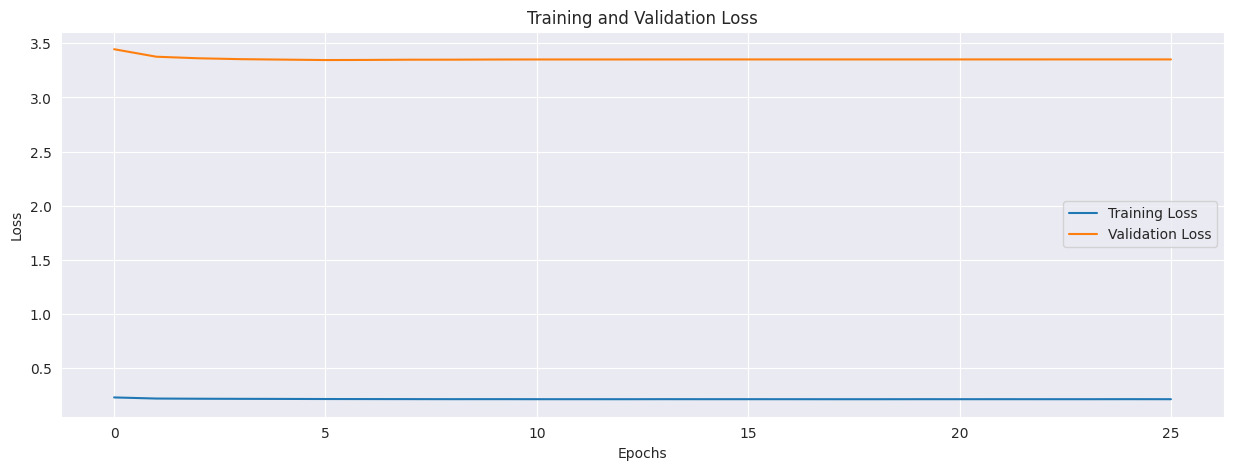

In [41]:
plot_loss_curves(history_lstm)

In [42]:
print("Performance on the training set")
pd.DataFrame(train_performance).T

Performance on the training set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,0.215797,0.346627,1911591.875,0.152747,-1585409.125,1.778157,-0.593847,0.822977


In [43]:
print("Performance on the validation set")
pd.DataFrame(val_performance).T

Performance on the validation set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,3.344824,3.861267,250.750122,3.414516,8.894439,125.572716,-0.158562,10.716795


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Kendall correlation coefficient (Tau): 0.029573821220245558
P-value for Kendall correlation: 0.06969415681906106
Wilcoxon statistic: 220232.0
P-value from Wilcoxon signed-rank test: 2.156804319561708e-134

Conclusion for Kendall's Tau:
The Kendall correlation between the prediction and the actual is not statistically significant.

Conclusion for Wilcoxon signed-rank test:
There is a statistically significant difference between the average predicted and actual values.


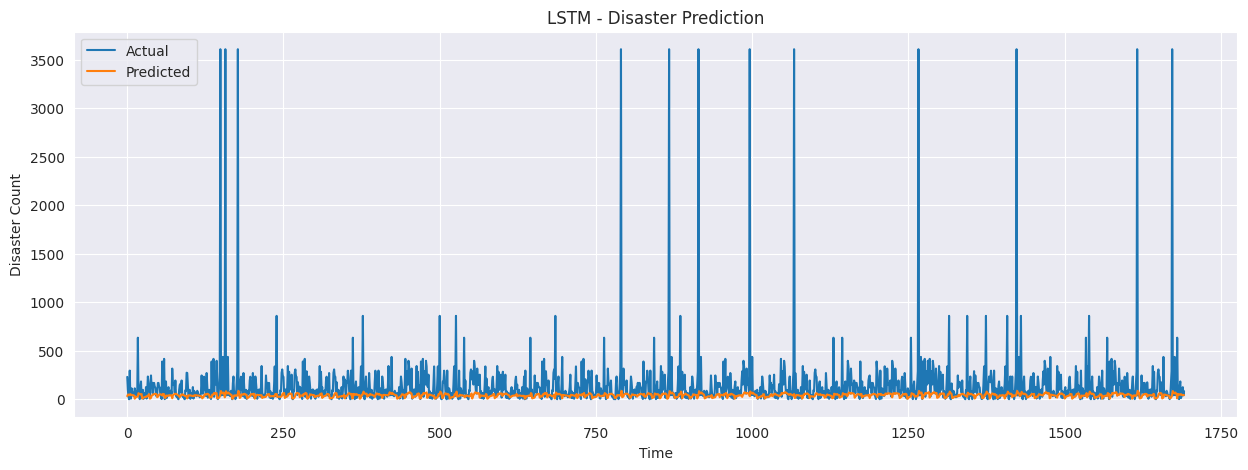

In [44]:
# Make predictions on the validation dataset
predictions_lstm = lstm_model.predict(X_val)  

# Reshape the true labels and the prediction
# y_val_reshape = y_val_log.reshape(-1, 1) 
y_val_reshape = y_val.reshape(-1, 1) 
predictions_lstm_reshape = predictions_lstm.reshape(-1, 1)  

# Apply inverse transformation 
predictions_lstm_original = scaler.inverse_transform(predictions_lstm_reshape)
y_val_original = scaler.inverse_transform(y_val_reshape)

# Directly apply inverse log transformation
# y_val_original = np.expm1(y_val_scaled)

# Perform Wilcoxon signed-rank test and Kendall correlation coefficient (non-normal distribution)
perform_wilcoxon_test_and_correlation(predictions_lstm_original, y_val_original)
    
# Plot the predictions against the true labels
plot_predictions(y_val_original, predictions_lstm_original, "LSTM")

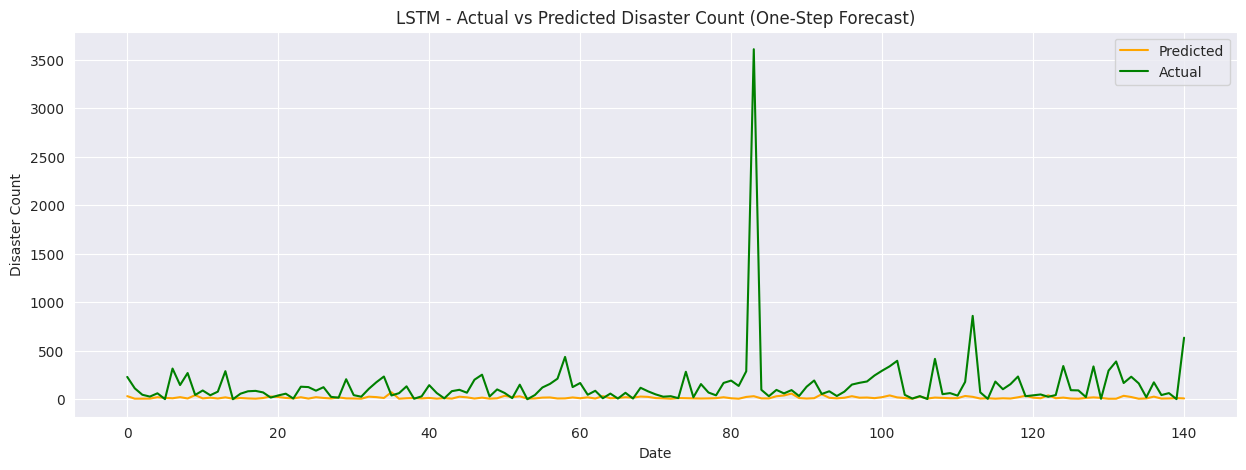

In [45]:
# Plot the first prediction from each sequence (one-step forecast)

plot_one_step_forecast(predictions_lstm_original, y_val_original, "LSTM")

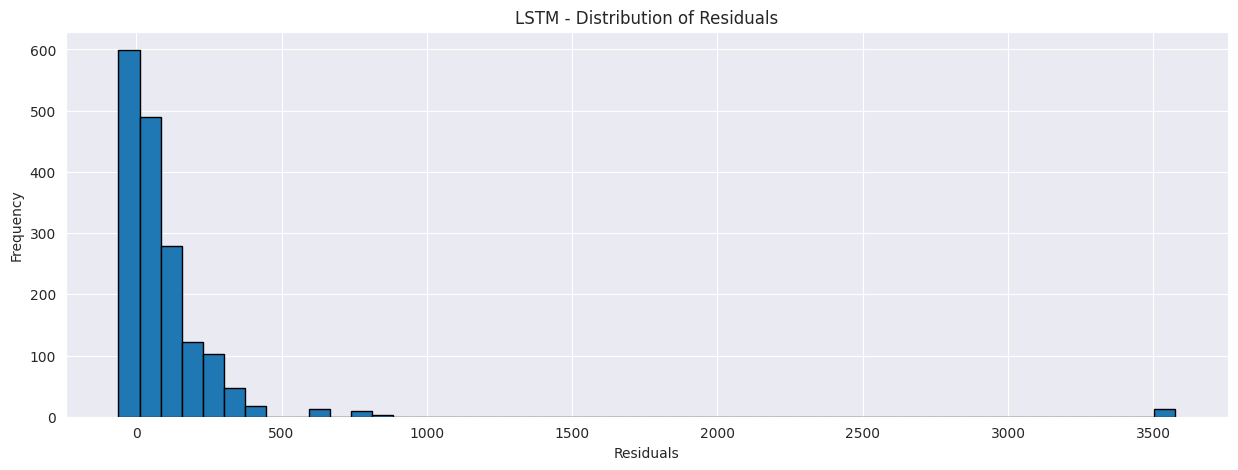

In [46]:
# Analyze residual
residuals_lstm = y_val_original - predictions_lstm_original

plot_residuals(residuals_lstm, "LSTM")

In [47]:
perform_breusch_pagan_test(predictions_lstm_original, residuals_lstm)

Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 1.8674035217598433
P-value: 0.17177275385849494

Homoscedasticity detected! The variance of the residual, or error term, in the regression model is constant.


/home/enge/.local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/enge/.local/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/enge/.local/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


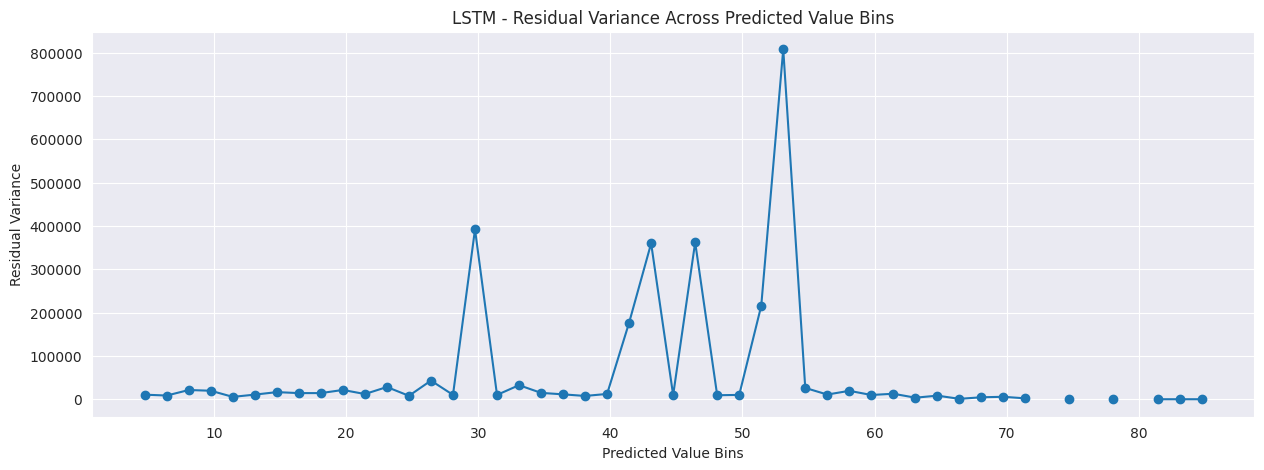

In [48]:
plot_residual_variance_across_prediction(predictions_lstm_original, residuals_lstm, "LSTM")

# Bi-LSTM

In [49]:
# Build the Bi-LSTM model
bi_lstm_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),  # m timesteps, n feature per timestep
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True)),
    tf.keras.layers.Dense(units=1)
])

# bi_lstm_model = tf.keras.models.Sequential([
#     tf.keras.Input(shape=INPUT_SHAPE),  
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_UNITS, activation='tanh', return_sequences=True,
#                                                        kernel_initializer=INITIALIZER_GLOROT_UNIFORM, 
#                                                        recurrent_initializer=INITIALIZER_ORTHOGONAL)),
#     tf.keras.layers.Dense(units=1, kernel_initializer=INITIALIZER_GLOROT_UNIFORM)
# ])




bi_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 254)        │       131,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12, 1)          │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,319 (512.96 KB)

 Trainable params: 131,319 (512.96 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Train Bi-LSTM Model
history_bi_lstm = compile_and_fit(bi_lstm_model,
                                  X_train_aug, y_train_aug, 
                                  X_val, y_val, 
                                  patience=PATIENCE, max_epochs=MAX_EPOCHS)

# Evaluate Bi-LSTM Model
train_performance['Bi-LSTM'] = bi_lstm_model.evaluate(X_train_aug, y_train_aug, return_dict=True)
val_performance['Bi-LSTM'] = bi_lstm_model.evaluate(X_val, y_val, verbose=1, return_dict=True)
performance['Bi-LSTM'] = bi_lstm_model.evaluate(X_test, y_test, verbose=0, return_dict=True)

Epoch 1/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2145 - mae: 0.3817 - mape: 1151575.3750 - me: 0.1380 - mpe: -1060665.7500 - mse: 1.7583 - r2: 0.0881 - rmse: 1.2087 - val_loss: 3.1528 - val_mae: 3.6643 - val_mape: 280.8684 - val_me: 3.1324 - val_mpe: -5.6628 - val_mse: 122.9526 - val_r2: -0.1176 - val_rmse: 10.5814 - learning_rate: 1.0000e-04
Epoch 2/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1932 - mae: 0.3176 - mape: 2964245.5000 - me: 0.1290 - mpe: -2668779.7500 - mse: 1.5505 - r2: 0.2227 - rmse: 1.1269 - val_loss: 3.0327 - val_mae: 3.5544 - val_mape: 326.1364 - val_me: 2.8269 - val_mpe: -27.9153 - val_mse: 120.6070 - val_r2: -0.0841 - val_rmse: 10.4622 - learning_rate: 1.0000e-04
Epoch 3/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1897 - mae: 0.3035 - mape: 3426343.2500 - me: 0.1305 - mpe: -3077745.5000 - mse: 1.4948 - r2: 0.2563 - rmse: 1.1042 - val_loss: 2.9922 - val_mae: 3.5150 - val_mape: 319.0847 - val_me: 2.7872 - val_mpe: -27.7378 - val_mse

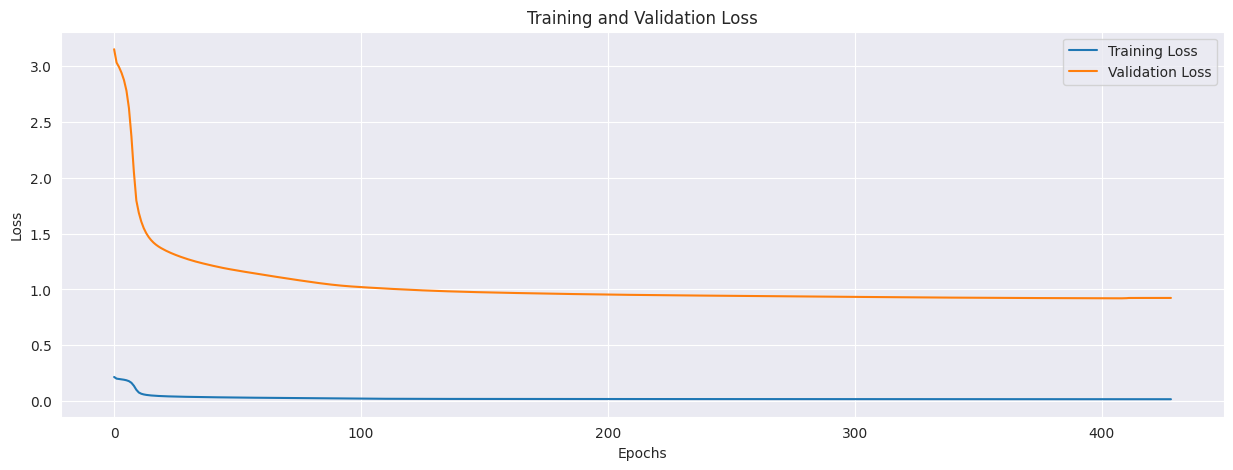

In [51]:
plot_loss_curves(history_bi_lstm)

In [52]:
print("Performance on the training set")
pd.DataFrame(train_performance).T

Performance on the training set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,0.215797,0.346627,1911591.875,0.152747,-1.585409e+06,1.778157,-0.593847,0.822977
Bi-LSTM,0.016593,0.042995,587437.125,0.006568,-1.913338e+05,0.132619,0.860237,0.195057


In [53]:
print("Performance on the validation set")
pd.DataFrame(val_performance).T

Performance on the validation set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,3.344824,3.861267,250.750122,3.414516,8.894439,125.572716,-0.158562,10.716795
Bi-LSTM,0.920751,1.102121,37.683678,0.947106,-0.111713,64.229530,0.515937,7.348334


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

Kendall correlation coefficient (Tau): 0.8596128974865977
P-value for Kendall correlation: 0.0
Wilcoxon statistic: 570758.5
P-value from Wilcoxon signed-rank test: 4.732910602092085e-13

Conclusion for Kendall's Tau:
The Kendall correlation between the prediction and the actual is statistically significant.

Conclusion for Wilcoxon signed-rank test:
There is a statistically significant difference between the average predicted and actual values.


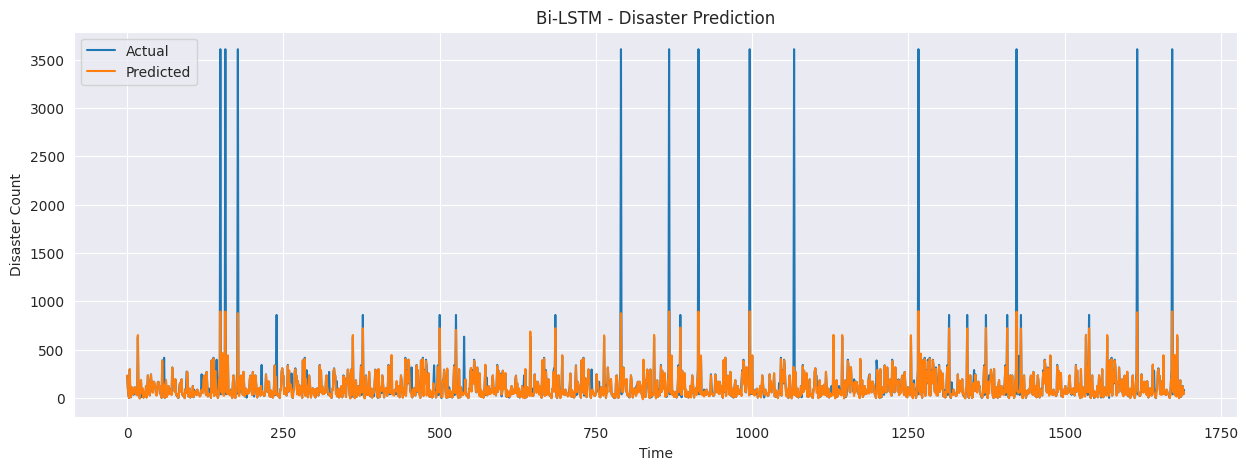

In [54]:
# Make predictions on the validation dataset
predictions_bilstm = bi_lstm_model.predict(X_val)  

# Reshape the true labels and the prediction
y_val_reshape = y_val.reshape(-1, 1) 
predictions_bilstm_reshape = predictions_bilstm.reshape(-1, 1)  

# Apply inverse transformation 
predictions_bilstm_original = scaler.inverse_transform(predictions_bilstm_reshape)
y_val_original = scaler.inverse_transform(y_val_reshape)

# Perform Wilcoxon signed-rank test and Kendall correlation coefficient (non-normal distribution)
perform_wilcoxon_test_and_correlation(predictions_bilstm_original, y_val_original)

# Plot the predictions against the true labels
plot_predictions(y_val_original, predictions_bilstm_original, "Bi-LSTM")

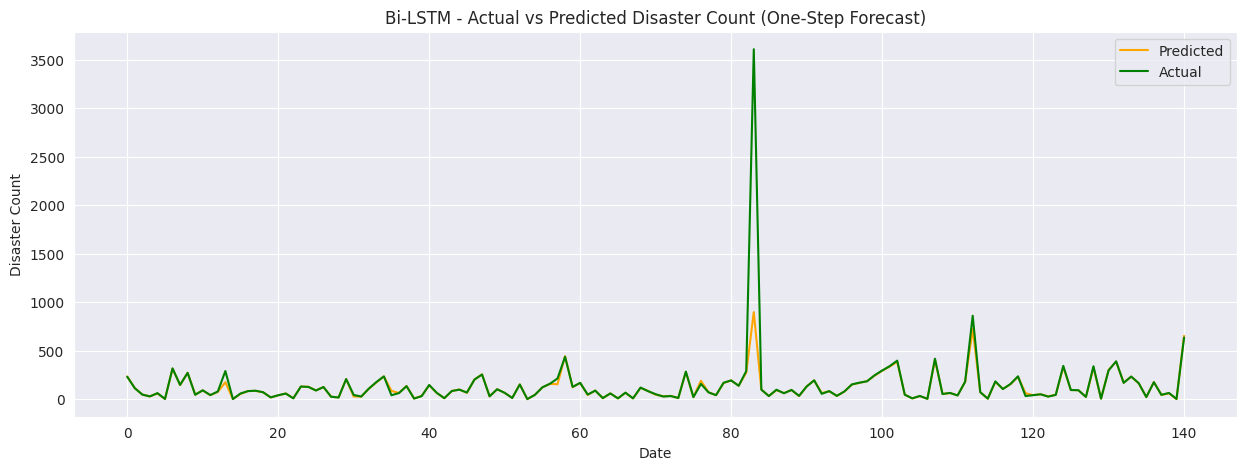

In [55]:
# Plot the first prediction from each sequence (one-step forecast)

plot_one_step_forecast(predictions_bilstm_original, y_val_original, "Bi-LSTM")

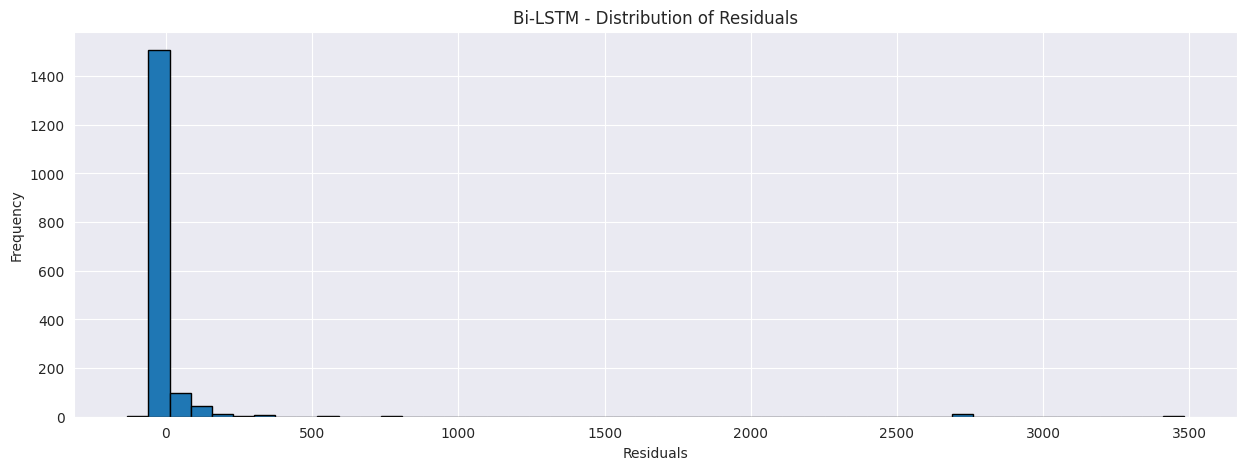

In [56]:
# Analyze residual
residuals_bilstm = y_val_original - predictions_bilstm_original

plot_residuals(residuals_bilstm, "Bi-LSTM")

In [57]:
perform_breusch_pagan_test(predictions_bilstm_original, residuals_bilstm)

Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 307.9227680506694
P-value: 6.190710893885905e-69

Heteroscedasticity detected! The variance of the residual, or error term, in the regression model is not constant.


/home/enge/.local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/enge/.local/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/enge/.local/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


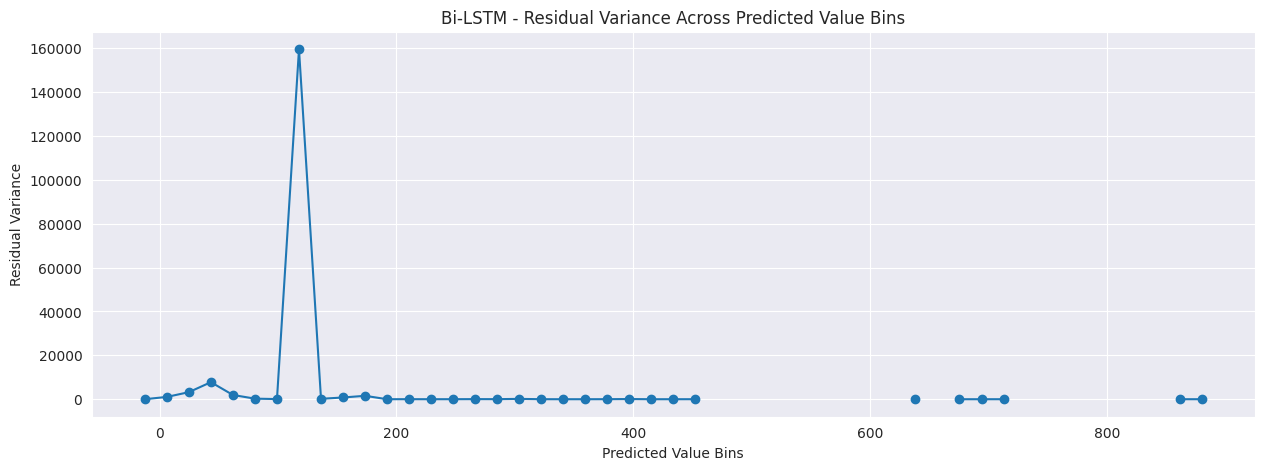

In [58]:
plot_residual_variance_across_prediction(predictions_bilstm_original, residuals_bilstm, "Bi-LSTM")

# GRU

The gated recurrent unit (GRU) is a variation of LSTM as both have design similarities, and in some cases, they produce similar results. GRU uses an update gate and reset gate to solve the vanishing gradient problem. These gates decide what information is important and pass it to the output. The gates can be trained to store information from long ago, without vanishing over time or removing irrelevant information.

Unlike LSTM, GRU does not have cell state $C_t$. It only has a hidden state $h_t$, and due to the simple architecture, GRU has a lower training time compared to LSTM models. The GRU architecture is easy to understand as it takes input $x_t$ and the hidden state from the previous timestamp $h_{t-1}$ and outputs the new hidden state $h_t$. 

In [59]:
# Build GRU model
gru_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),  # m timesteps, n feature per timestep
    tf.keras.layers.GRU(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(HIDDEN_UNITS, activation='tanh', seed=SEED, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

# gru_model = tf.keras.models.Sequential([
#     tf.keras.Input(shape=INPUT_SHAPE), 
#     tf.keras.layers.GRU(HIDDEN_UNITS, activation='tanh', return_sequences=True,
#                         kernel_initializer=INITIALIZER_GLOROT_UNIFORM, 
#                         recurrent_initializer=INITIALIZER_ORTHOGONAL),
#     tf.keras.layers.GRU(HIDDEN_UNITS, activation='tanh', return_sequences=True,
#                         kernel_initializer=INITIALIZER_GLOROT_UNIFORM, 
#                         recurrent_initializer=INITIALIZER_ORTHOGONAL),
#     tf.keras.layers.Dense(units=1, kernel_initializer=INITIALIZER_GLOROT_UNIFORM)
# ])



gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 127)        │        49,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 127)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 12, 127)        │        97,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 127)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12, 1)          │           128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,194 (574.98 KB)

 Trainable params: 147,194 (574.98 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train GRU Model
history_gru = compile_and_fit(gru_model,
                              X_train_aug, y_train_aug, 
                              X_val, y_val, 
                              patience=PATIENCE, max_epochs=MAX_EPOCHS)

# Evaluate GRU Model
train_performance['GRU'] = gru_model.evaluate(X_train_aug, y_train_aug, return_dict=True)
val_performance['GRU'] = gru_model.evaluate(X_val, y_val, verbose=1, return_dict=True)
performance['GRU'] = gru_model.evaluate(X_test, y_test, verbose=0, return_dict=True)


Epoch 1/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2224 - mae: 0.3899 - mape: 782360.9375 - me: 0.1465 - mpe: -632124.6250 - mse: 1.8169 - r2: 0.0466 - rmse: 1.2322 - val_loss: 3.2803 - val_mae: 3.8032 - val_mape: 310.2791 - val_me: 3.1072 - val_mpe: -15.4007 - val_mse: 124.1455 - val_r2: -0.1356 - val_rmse: 10.6421 - learning_rate: 1.0000e-04
Epoch 2/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2085 - mae: 0.3360 - mape: 1657552.0000 - me: 0.1465 - mpe: -1266857.8750 - mse: 1.6989 - r2: 0.1320 - rmse: 1.1853 - val_loss: 3.3016 - val_mae: 3.8248 - val_mape: 285.5799 - val_me: 3.2328 - val_mpe: -6.6307 - val_mse: 124.5991 - val_r2: -0.1439 - val_rmse: 10.6673 - learning_rate: 1.0000e-04
Epoch 3/2000
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2075 - mae: 0.3364 - mape: 1552549.1250 - me: 0.1470 - mpe: -1181808.5000 - mse: 1.7033 - r2: 0.1303 - rmse: 1.1867 - val_loss: 3.2967 - val_mae: 3.8187 - val_mape: 283.5804 - val_me: 3.2357 - val_mpe: -7.1059 - val_mse:

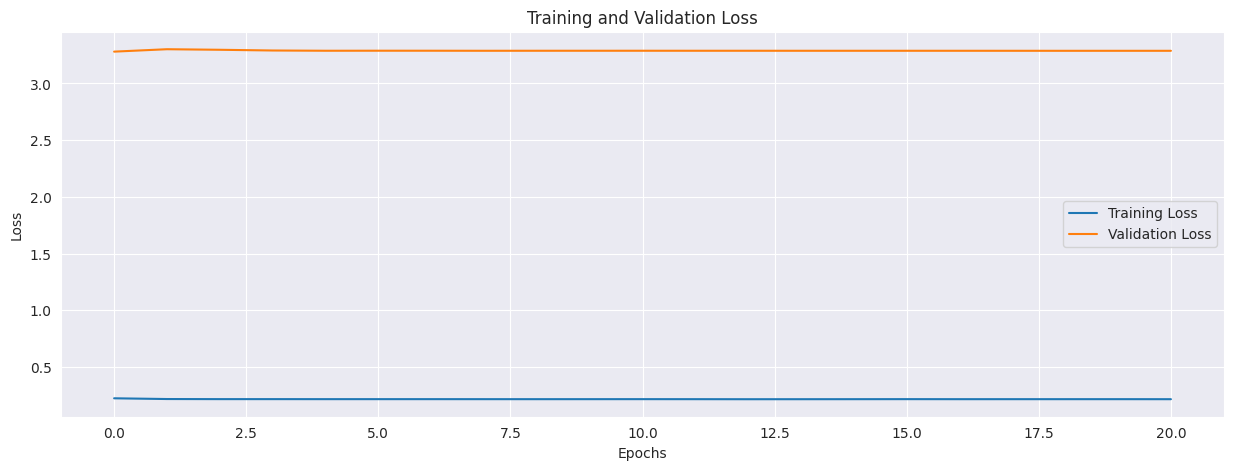

In [61]:
plot_loss_curves(history_gru)

In [62]:
print("Performance on the training set")
pd.DataFrame(train_performance).T

Performance on the training set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,0.215797,0.346627,1911591.875,0.152747,-1.585409e+06,1.778157,-0.593847,0.822977
Bi-LSTM,0.016593,0.042995,587437.125,0.006568,-1.913338e+05,0.132619,0.860237,0.195057
GRU,0.217400,0.344252,1835118.000,0.148388,-1.470194e+06,1.771697,-0.454221,0.818623


In [63]:
print("Performance on the validation set")
pd.DataFrame(val_performance).T

Performance on the validation set


,loss,mae,mape,me,mpe,mse,r2,rmse
LSTM,3.344824,3.861267,250.750122,3.414516,8.894439,125.572716,-0.158562,10.716795
Bi-LSTM,0.920751,1.102121,37.683678,0.947106,-0.111713,64.229530,0.515937,7.348334
GRU,3.280300,3.803230,310.279083,3.107187,-15.400732,124.145462,-0.135556,10.642143


In [64]:
# New
# scaler = robust  alpha=10
#           loss	    mae     	mape       	me	        mpe	        r2	        rmse
# LSTM	3.358945	3.757903	237.071777	-3.412223	-15.866794	-0.110661	10.682772
# Bi-LSTM	0.939089	1.094532	43.166260	-0.955870	-6.573349	0.400999	7.877890
# GRU	3.346857	3.745588	246.325150	-3.379931	-11.062410	-0.109290	10.676303

# scaler = minmax alpha=10
#           loss    	mae	        mape	    me	        mpe	        r2	        rmse
# LSTM	0.041940	0.144875	1421588.500	-0.104408	1421517.125	-0.089790	0.406641
# Bi-LSTM	0.035581	0.130893	1721970.375	-0.047605	1721930.375	0.126293	0.364871
# GRU	0.042944	0.148011	1325548.375	-0.095941	1325479.375	-0.097203	0.407939

# scaler = robust  alpha=5, batch_size=16 data agmentation, optimizer=RMSprop
#           loss    	mae	        mape        	me	    mpe	        r2	        rmse
# LSTM	3.295512	3.812038	264.962036	-3.304238	-2.215791	-0.144311	10.665119
# Bi-LSTM	0.909083	1.101341	35.408108	-0.934870	-4.437493	0.503853	7.438524
# GRU	3.272295	3.791054	281.632019	-3.231870	5.190224	-0.138436	10.644940

# scaler = robust  alpha=5, batch_size=16, data agmentation, optimizer=Adam
# Bi-LSTM	0.919648	1.106695	35.495235	-0.964332	-1.364128	0.518114	7.330561

# scaler = robust  alpha=2, batch_size=16, data agmentation, optimizer=Adam
# Bi-LSTM	0.909531	1.101606	33.786469	0.932248	1.962388	60.455006	0.542398	7.138612
# scaler = robust  alpha=3, batch_size=16, data agmentation, optimizer=Adam
# Bi-LSTM	0.925707	1.114118	35.382492	0.929080	3.790551	62.809559	0.525499	7.272006
# alpha=4
# Bi-LSTM	0.945266	1.140924	35.954979	0.976620	8.303221	64.134537	0.514669	7.352458
# alpha=6
# Bi-LSTM	0.920751	1.102121	37.683678	0.947106	-0.111713	64.229530	0.515937	7.348334


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7b2392143880> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step

Kendall correlation coefficient (Tau): 0.023192842958437508
P-value for Kendall correlation: 0.1548750171601124
Wilcoxon statistic: 297678.0
P-value from Wilcoxon signed-rank test: 2.9331877464526133e

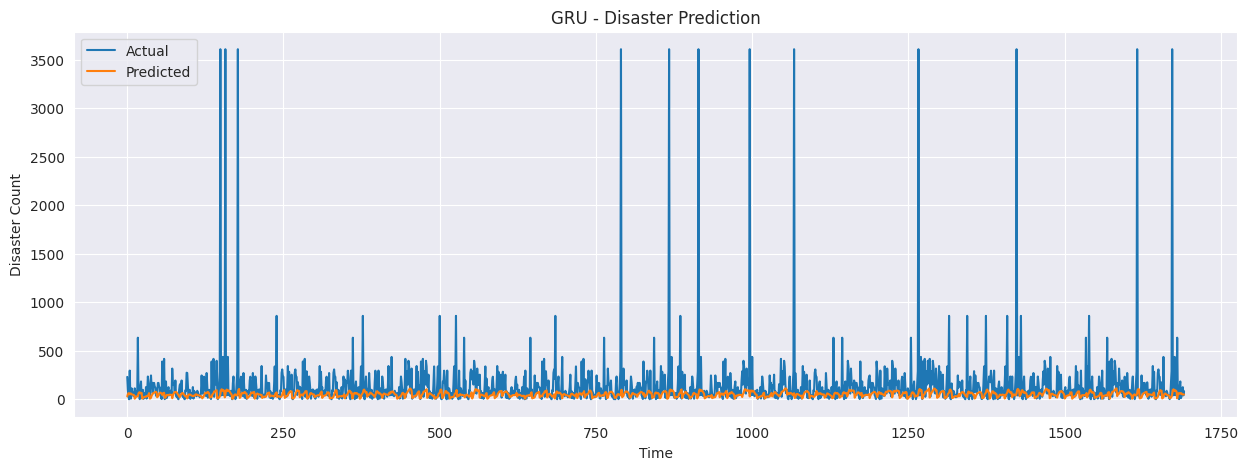

In [65]:
# Make predictions on the validation dataset
predictions_gru = gru_model.predict(X_val)  

# Reshape the true labels and the prediction
y_val_reshape = y_val.reshape(-1, 1) 
predictions_gru_reshape = predictions_gru.reshape(-1, 1)  

# Apply inverse transformation 
predictions_gru_original = scaler.inverse_transform(predictions_gru_reshape)
y_val_original = scaler.inverse_transform(y_val_reshape)

# Perform Wilcoxon signed-rank test and Kendall correlation coefficient (non-normal distribution)
perform_wilcoxon_test_and_correlation(predictions_gru_original, y_val_original)

# Plot the predictions against the true labels
plot_predictions(y_val_original, predictions_gru_original, "GRU")

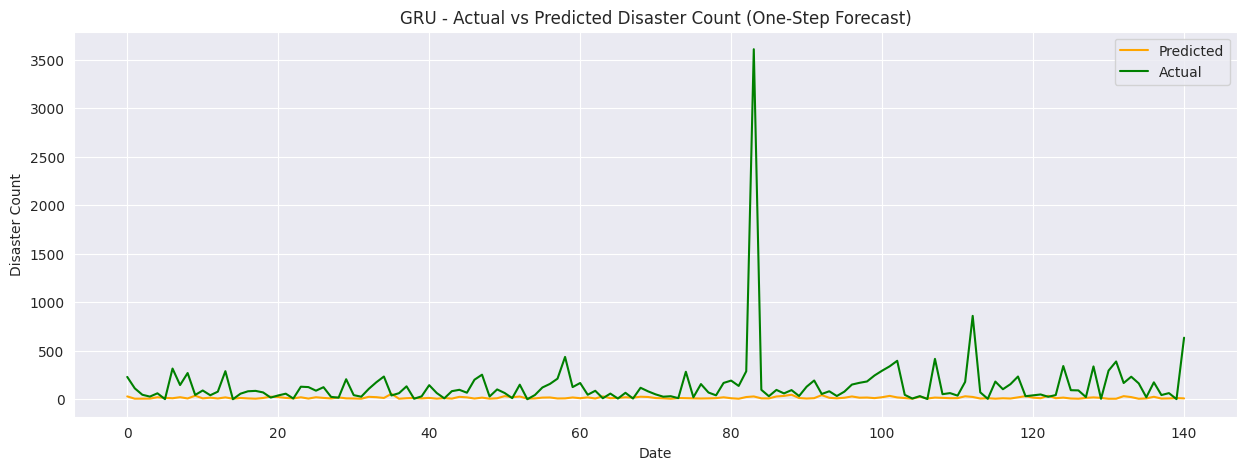

In [66]:
# Plot the first prediction from each sequence (one-step forecast)

plot_one_step_forecast(predictions_gru_original, y_val_original, "GRU")

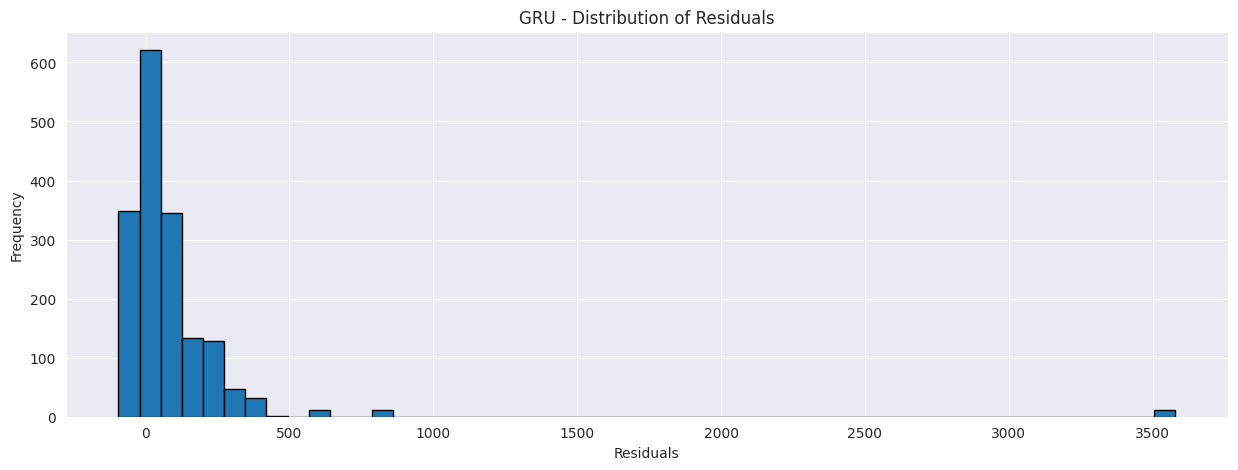

In [67]:
# Analyze residual
residuals_gru = y_val_original - predictions_gru_original

plot_residuals(residuals_gru, "GRU")

In [68]:
perform_breusch_pagan_test(predictions_gru_original, residuals_bilstm)

Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 0.14581869770471245
P-value: 0.7025636202931865

Homoscedasticity detected! The variance of the residual, or error term, in the regression model is constant.


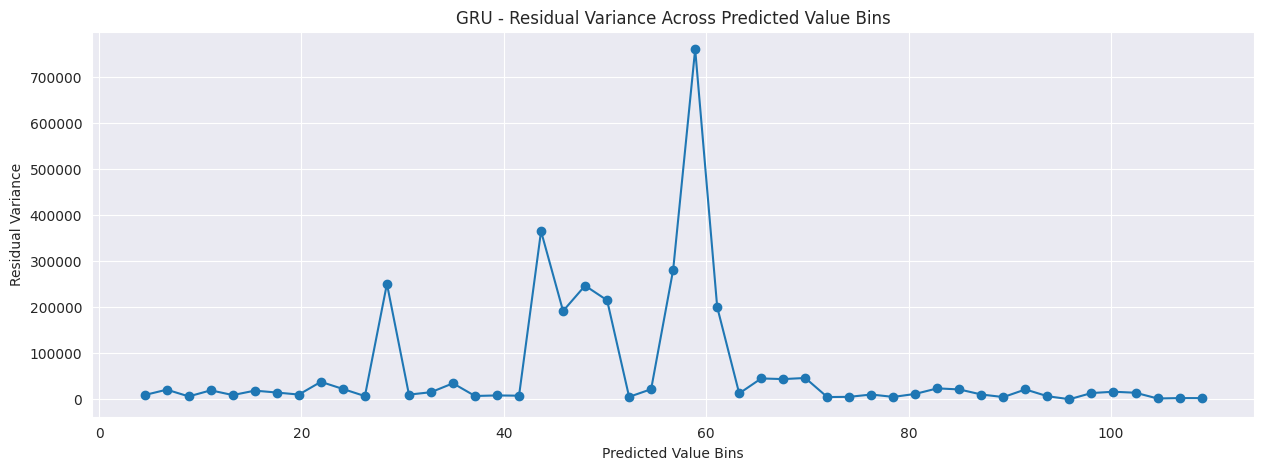

In [69]:
plot_residual_variance_across_prediction(predictions_gru_original, residuals_gru, "GRU")

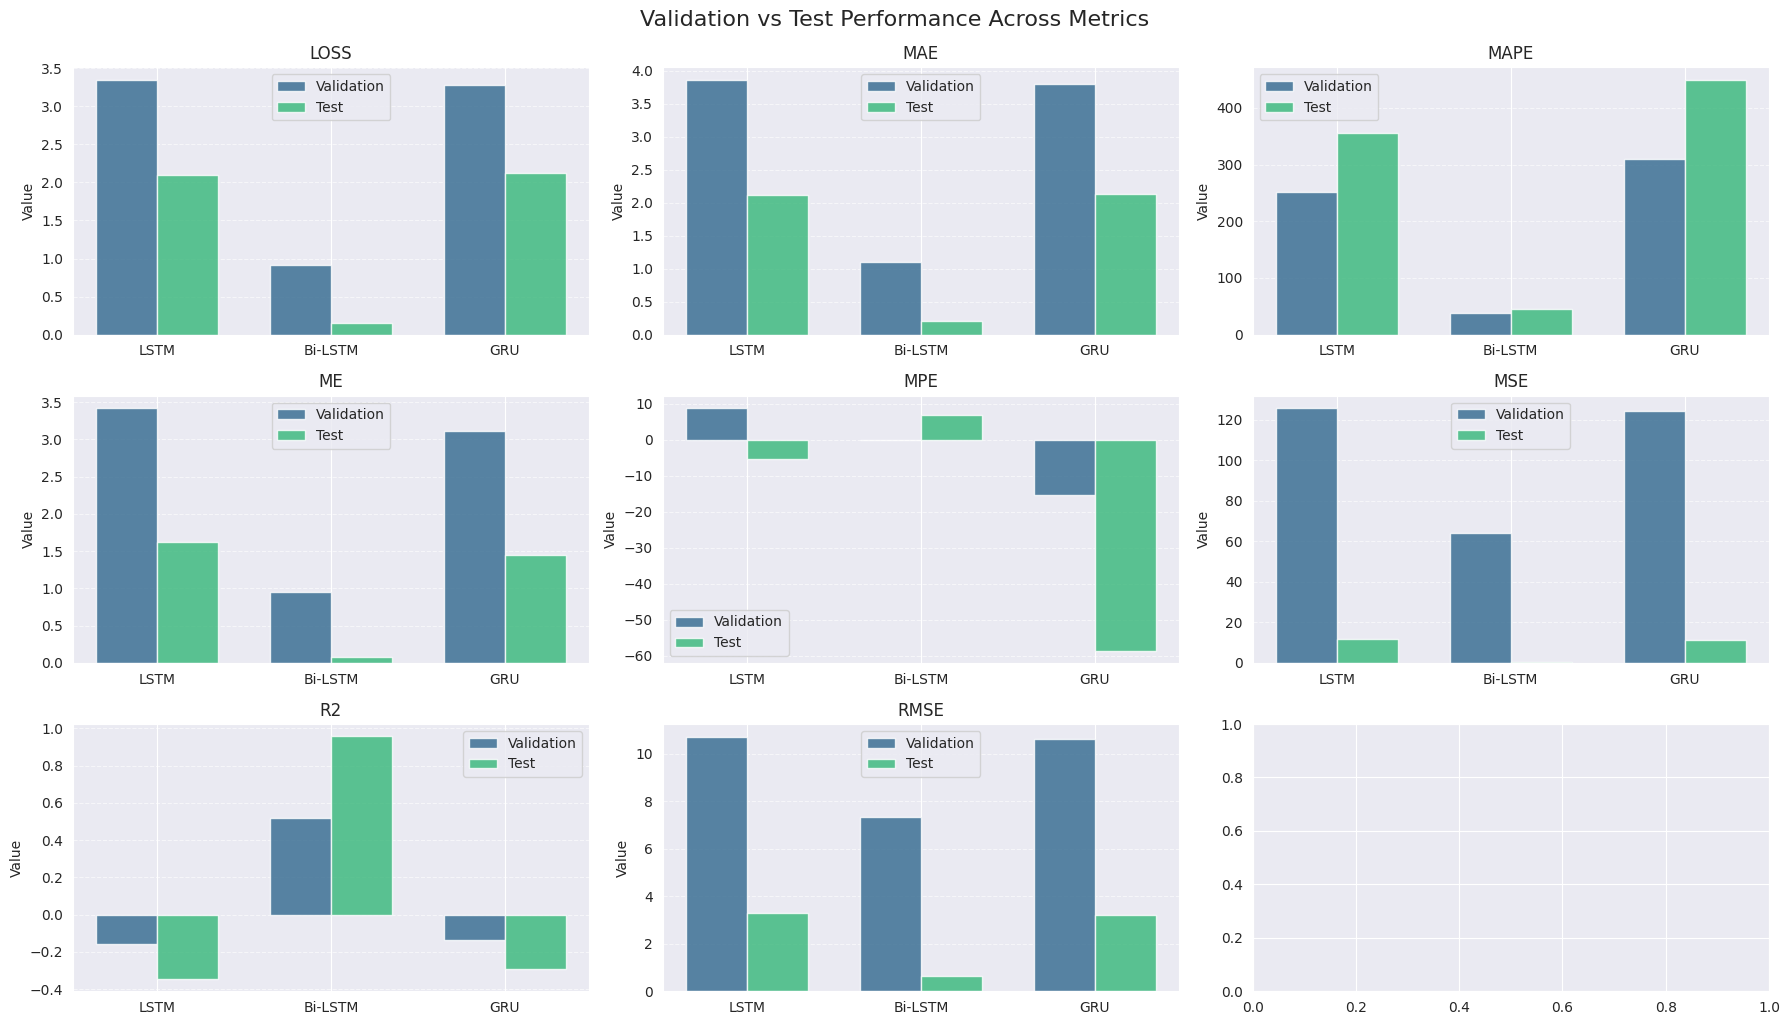

In [70]:
# Extract metrics and models
metrics = list(val_performance['LSTM'].keys())
models = list(val_performance.keys())

# Create a seaborn color palette
palette = sns.color_palette("viridis", 2)  

# Plot
fig, axes = plt.subplots(3, 3, figsize=(18, 10))  
axes = axes.flatten()  

# Plot each metric in its own subplot
for i, metric_name in enumerate(metrics):
    ax = axes[i]
    
    # Get validation and test performance for the current metric
    val_ = [v[metric_name] for v in val_performance.values()]
    test_ = [v[metric_name] for v in performance.values()]
    
    x = np.arange(len(models))  # Position of bars
    width = 0.35  # Bar width
    
    # Bar plots for validation and test
    ax.bar(x - width/2, val_, width, label='Validation', color=palette[0], alpha=0.8)
    ax.bar(x + width/2, test_, width, label='Test', color=palette[1], alpha=0.8)
    
    # Title and labels
    ax.set_title(metric_name.upper())
    ax.set_ylabel("Value")
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.suptitle("Validation vs Test Performance Across Metrics", y=1.02, fontsize=16)  
plt.show()
